### Ensemble-Epidemiology to Contextualize Healthy Aging in an Observational Setting: Overcoming Genetic Risk for Type 2 Diabetes and Kidney Disease in UKBB from Behavior Modification

-----------------------------
## **Importance**
-----------------------------
-Kidney disease is a common microvascular complication of type 2 diabetes (T2D). There is significant variability in KD disease onset and progression. Recent evidence suggests clinicians may stratify those at increased risk of diabetic complications using polygenic risk scores among those with and without T2D. Individuals who have a high genetic risk of kidney disease may lower their risk of disease more when engaging in these healthier behaviors relatively speaking as copmared to individuals with low risk of disease.

-----------------------------
## **Context**
-----------------------------

-Unsupervised learning and ensemble modeling within an epidemiological framework may contextualize an individual’s experience and clarify contextual factors at multiple levels of the socio-ecological model.

-Multiple exposures may modify associations in a parsimonious model that is statistically efficient, since oftentimes, a constellation of causes contribute to disease risk as posited by the causal pie model. Complex, interrelated features that predict decline in physical functioning. 

-This conundrum is that epidemiology is often testing one exposure-outcome relationship; yet, many advanced methods in causal inference aim to estimate the association in the absence of bias aims to remove contextual information. 

-Contextual information can remain intact by clustering of risk factors and disease. 

-This notebook aims to accomplish the following: (i) identify behavioral profiles and compare/contrast the profiles using various clustering approaches, (ii) assess associations between individualized profiles wtih type 2 diabetes and diabetic complications, and (iii) test for interactions between the behavioral profiles with polygenic risk score with the diabetic kidney complications.

In [167]:
import pandas as pd
import tensorflow as tf

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
#from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import silhouette_score
# For tuning the model
from sklearn.model_selection import GridSearchCV
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#modeling (logistic regression)
from scipy import stats
from statsmodels.formula.api import logit
from statsmodels.formula.api import probit
from statsmodels.formula.api import glm
import statsmodels.api as sm

In [168]:
#!pip install statsmodels --user

### **Loading the dataset**

In [169]:
# Reading the dataset that is tab=de
MyTextFileReader = pd.read_csv('/salemlab/users/agarduno/jupyter/UKBB_AG2_23April21norestrict.txt', sep='\t', chunksize=10000)
df = pd.concat(MyTextFileReader, ignore_index=True)

In [170]:
print(df.shape)
df.head()

(502507, 427)


,f.eid,SEX.0.0,YOB.0.0,VISDATE.0.0,FASTTIME.0.0,SBP.0.0,SBP.0.1,SBPm.0.0,SBPm.0.1,DBPm.0.0,DBPm.0.1,SES_TDI.0.0,EXERTIME.0.0,DBP.0.0,DBP.0.1,BP_MTD.0.0,BP_MTD.0.1,ALCFREQ.0.0,PREGNANT.0.0,EDUCATION.0.0,SMOKE.0.0,CURRALC.0.0,CURRALC.1.0,ETHNICITY.0.0,BMI.0.0,AGE_BASE.0.0,URN_ALBUMIN.0.0,URN_ALBUMIN_FLAG.0.0,URN_CREATININE.0.0,URN_CREATININE_FLAG.0.0,CREATININE_SRM.0.0,CYSTATIN_SRM.0.0,GLUCOSE.0.0,HBA1C.0.0,HDL.0.0,LDL.0.0,TRIG.0.0,URIC_ACID_SRM.0.0,MODEX.0.0,DIAB_SDX.0.0,DIAB_AGE.0.0,DIAB_SDX_INS.0.0,GDMONLY.0.0,ESRDDATE.0.0,ESRDSOURCE.0.0,E10SOURCE.0.0,E11SOURCE.0.0,DOC_HEART.0.0,DOC_HEART.0.1,DOC_HEART.0.2,DOC_HEART.0.3,FID,IID.x,GRS_RAW_LIR,GRS_WT_LIR,IID.y,GRS_RAW_IR,GRS_WT_IR,IID.x.1,GRS_RAW_IR53,GRS_WT_IR53,IID.y.1,GRS_RAW_T2DIR,GRS_WT_T2DIR,IID.x.2,rs1121980.x,rs1167827.x,rs11963900.x,rs2195246.x,rs2791550.x,rs2943641.x,rs459193.x,rs4865796.x,rs731839.x,rs780093.x,rs7903146.x,rs7985878.x,rs983309.x,rs9884482.x,GRS_RAW_L5E8IR,GRS_WT_L5E8IR,IID.y.2,rs10113954,rs10224545,rs10810601,rs10887816,rs10938397,rs111908763,rs1121980.y,rs1128249,rs114337026,rs116107987,rs1167827.y,rs11708067,rs11786361,rs11818333,rs11963900.y,rs12334877,rs12413420,rs12801888,rs13013358,rs13066686,rs13210323,rs138351201,rs1412235,rs1425486,rs1448733,rs147249866,rs1530559,rs1553261,rs17120351,rs17169104,rs17474773,rs1936805,rs2195246.y,rs2627271,rs2710157,rs2737219,rs2791550.y,rs2943641.y,rs2946834,rs2973572,rs3075537,rs34032140,rs34863433,rs4566098,rs459193.y,rs4804833,rs4865796.y,rs4992980,rs534668,rs552962182,rs55726019,rs62240864,rs62260788,rs62446933,rs6425364,rs6430612,rs658982,rs67861770,rs6881703,rs7041847,rs7138803,rs7260957,rs731177,rs73126355,rs731839.y,rs73908707,rs75131305,rs75539911,rs75714016,rs7585344,rs7640424,rs7798471,rs780093.y,rs78896181,rs7903146.y,rs79528467,rs7970953,rs7985878.y,rs8096799,rs897109,rs983309.y,rs9884482.y,GRS_RAW_L1E5IR,GRS_WT_L1E5IR,IID,IID_Salem,WAIST.0.0,WAIST.1.0,WAIST.2.0,WAIST.3.0,HIP.0.0,HIP.1.0,HIP.2.0,HIP.3.0,RACE,SASIAN,CARIBN,CREATININE_SRM2.0.0,EGFR.0.0,EGFR_flag.0.0,URN_CREATININE2.0.0,ACR.0.0,ALBUMINERIA.0.0,ESKD.0.0,CKD.0.0,DN.0.0,ALL.0.0,NONESKD.0.0,DNCKD.0.0,CTRL_DNCKD.0.0,DM1_PROB5,DM_POS3,DM_POS7,E11_FO,T2D.0.0,AKISOURCE.0.0.x,T2D_status,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,TOTAL_INCOME.0.0,TOTAL_INCOME.1.0,TOTAL_INCOME.2.0,TOTAL_INCOME.3.0,FREQ_WK_MOD_PHY.0.0,FREQ_WK_MOD_PHY.1.0,FREQ_WK_MOD_PHY.2.0,FREQ_WK_MOD_PHY.3.0,DUR_MOD_PHY.0.0,DUR_MOD_PHY.1.0,DUR_MOD_PHY.2.0,DUR_MOD_PHY.3.0,FREQ_WK_VIG_PHY.0.0,FREQ_WK_VIG_PHY.1.0,FREQ_WK_VIG_PHY.2.0,FREQ_WK_VIG_PHY.3.0,DUR_VIG_PHY.0.0,DUR_VIG_PHY.1.0,DUR_VIG_PHY.2.0,DUR_VIG_PHY.3.0,DIET_COOK_VEG.0.0,DIET_COOK_VEG.1.0,DIET_COOK_VEG.2.0,DIET_COOK_VEG.3.0,DIET_SALAD_RAW.0.0,DIET_SALAD_RAW.1.0,DIET_SALAD_RAW.2.0,DIET_SALAD_RAW.3.0,DIET_FRUIT_FRESH.0.0,DIET_FRUIT_FRESH.1.0,DIET_FRUIT_FRESH.2.0,DIET_FRUIT_FRESH.3.0,DIET_FRUIT_DRY.0.0,DIET_FRUIT_DRY.1.0,DIET_FRUIT_DRY.2.0,DIET_FRUIT_DRY.3.0,DIET_OIL_FISH.0.0,DIET_OIL_FISH.1.0,DIET_OIL_FISH.2.0,DIET_OIL_FISH.3.0,DIET_NO_OIL_FISH.0.0,DIET_NO_OIL_FISH.1.0,DIET_NO_OIL_FISH.2.0,DIET_NO_OIL_FISH.3.0,DIET_PROC_MEAT.0.0,DIET_PROC_MEAT.1.0,DIET_PROC_MEAT.2.0,DIET_PROC_MEAT.3.0,DIET_POULTRY.0.0,DIET_POULTRY.1.0,DIET_POULTRY.2.0,DIET_POULTRY.3.0,DIET_BEEF.0.0,DIET_BEEF.1.0,DIET_BEEF.2.0,DIET_BEEF.3.0,DIET_LAMB.0.0,DIET_LAMB.1.0,DIET_LAMB.2.0,DIET_LAMB.3.0,DIET_PORK.0.0,DIET_PORK.1.0,DIET_PORK.2.0,DIET_PORK.3.0,DIET_CHEESE.0.0,DIET_CHEESE.1.0,DIET_CHEESE.2.0,DIET_CHEESE.3.0,DIET_MILK.0.0,DIET_MILK.1.0,DIET_MILK.2.0,DIET_MILK.3.0,DIET_SPREAD.0.0,DIET_SPREAD.1.0,DIET_SPREAD.2.0,DIET_SPREAD.3.0,DIET_BREAD_SLICESWK.0.0,DIET_BREAD_SLICESWK.1.0,DIET_BREAD_SLICESWK.2.0,DIET_BREAD_SLICESWK.3.0,DIET_BREAD_TYPE.0.0,DIET_BREAD_TYPE.1.0,DIET_BREAD_TYPE.2.0,DIET_BREAD_TYPE.3.0,DIET_CBOWLSWK.0.0,DIET_CBOWLSWK.1.0,DIET_CBOWLSWK.2.0,DIET_CBOWLSWK.3.0,DIET_CTYPE.0.0,DIET_CTYPE.1.0,DIET_CTYPE.2.0,DIET_CTYPE.3.0,DIET_SPREAD_TYPE.0.0,DIET_SPREAD_TYPE.1.0,DIET_SPREAD_TYPE.2.0,DIET_SPREAD_TYPE.3.0,DIET_RECAGE_MEAT.0.0,DIET_RECAGE_MEAT.1.0,

In [171]:
#Read the sleep dataset
MyTextFileReader2 = pd.read_csv('/salemlab/users/agarduno/t32/sleep2021/dd_sleep/UKBBsleep_20210422.txt', sep='\t', chunksize=10000)
df2 = pd.concat(MyTextFileReader2, ignore_index=True)

In [172]:
#merge the datasets
df3 = pd.merge(df,df2,on='f.eid',how='outer')
del df 
del df2

In [173]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
#print(df3.columns.tolist())

In [174]:
#df3.nunique()

#### Descriptives for numerical variables

In [175]:
num_cols = ['MOD_TOT','VIG_TOT','FREQ_WK_MOD_PHY.0.0','FREQ_WK_VIG_PHY.0.0','WHR.0.0','DIET_COOK_VEG.0.0','DIET_SALAD_RAW.0.0','DIET_FRUIT_FRESH.0.0','SLEEPDUR.0.0','SUNLAMP.0.0','SES_TDI.0.0','EDUYEARS',
           'DIET_BEEF_SERV.0.0','DIET_UNPROC.0.0']
df3.get(num_cols).describe()

,MOD_TOT,VIG_TOT,FREQ_WK_MOD_PHY.0.0,FREQ_WK_VIG_PHY.0.0,WHR.0.0,DIET_COOK_VEG.0.0,DIET_SALAD_RAW.0.0,DIET_FRUIT_FRESH.0.0,SLEEPDUR.0.0,SUNLAMP.0.0,SES_TDI.0.0,EDUYEARS,DIET_BEEF_SERV.0.0,DIET_UNPROC.0.0
count,472179.000000,472938.000000,501615.000000,501615.000000,483617.000000,484883.000000,471209.000000,483375.000000,501606.000000,497804.000000,500216.000000,490740.000000,499170.000000,502507.000000
mean,250.768276,85.146994,3.373504,1.671236,0.871742,2.779473,2.273318,2.292148,7.098571,0.001008,-1.296549,13.950893,2.029852,8.148617
std,444.721543,195.255303,2.515288,2.039933,0.089800,1.919813,2.176180,1.608356,1.301192,5.025431,3.093544,5.136835,1.154721,3.220245
min,-21.000000,-21.000000,-3.000000,-3.000000,0.200000,0.000000,0.000000,0.000000,-3.000000,-10.000000,-6.258260,7.000000,0.000000,0.000000
25%,15.000000,0.000000,1.000000,0.000000,0.803738,2.000000,1.000000,1.000000,6.000000,0.000000,-3.642510,10.000000,1.000000,6.000000
50%,90.000000,20.000000,3.000000,1.000000,0.872881,2.000000,2.000000,2.000000,7.000000,0.000000,-2.137770,13.000000,3.000000,9.000000
75%,300.000000,100.000000,5.000000,3.000000,0.936842,3.000000,3.000000,3.000000,8.000000,0.000000,0.545059,20.000000,3.000000,10.000000
max,10080.000000,10080.000000,7.000000,7.000000,2.966667,50.000000,50.000000,50.000000,23.000000,900.000000,11.001300,20.000000,3.000000,12.000000


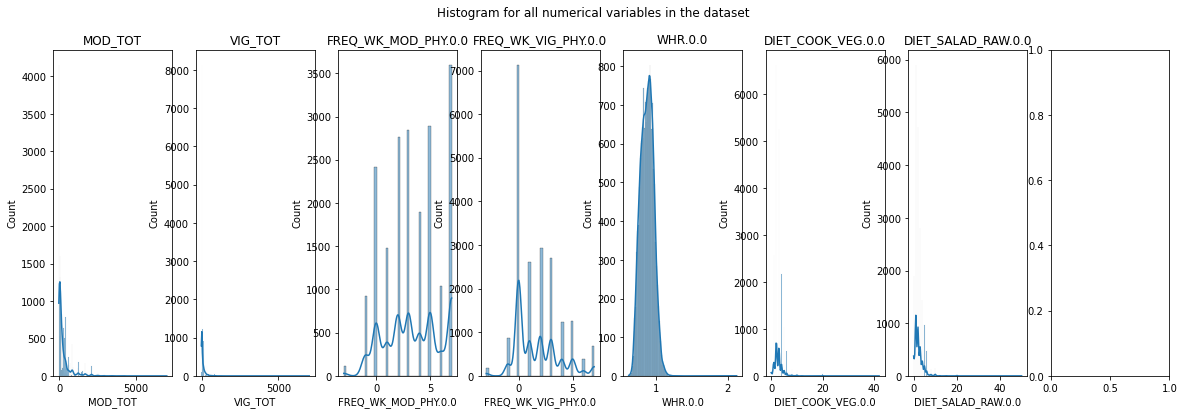

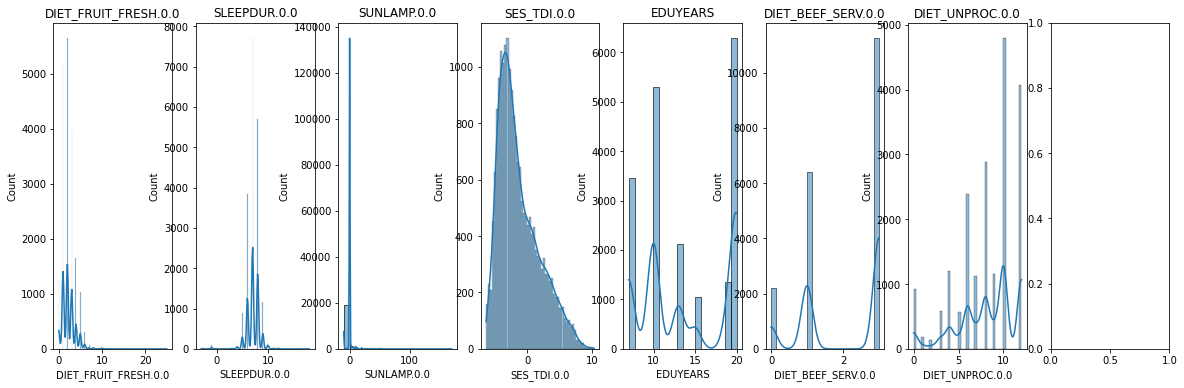

In [176]:
fig, axes = plt.subplots(1,8, figsize = (20, 6))

#plot a randomly sampled subset
subset=df3.sample(n = 20000)
  
fig.suptitle('Histogram for all numerical variables in the dataset')
for count,index in enumerate(num_cols):
    if count < 7:
        axes[count].set_title(index)
        sns.histplot(x = index, data = subset, kde = True, ax = axes[count]);
    elif count == 7:
        fig, axes = plt.subplots(1,8, figsize = (20, 6))
        #plot a randomly sampled subset
        count = count - 7
        axes[count].set_title(index)
        sns.histplot(x = index, data = subset, kde = True, ax = axes[count]);
    elif count > 7:
        count = count - 7
        axes[count].set_title(index)
        sns.histplot(x = index, data = subset, kde = True, ax = axes[count]);

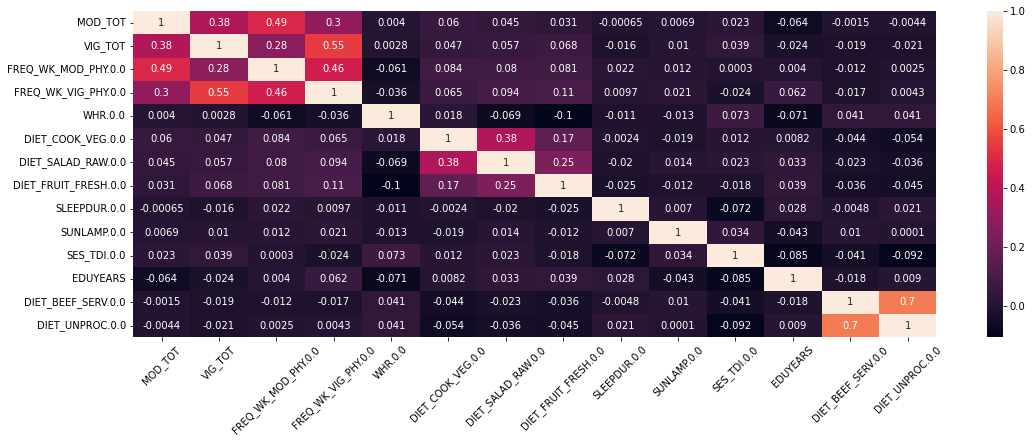

In [177]:
fig = plt.figure(figsize = (18, 6))
sns.heatmap(subset.get(num_cols).corr(), annot = True);
plt.xticks(rotation = 45);

### Scale the data using standard scaling 

Clustering algorithms are distance-based algorithms, and all distance-based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering.

In [178]:
subset=df3.get(num_cols)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(subset), columns = subset.columns)
data_scaled_copy = data_scaled.copy(deep = True) #creating copy of the data to store labels from each algorithm
# Impute for median value for missing NAs, imputation less sensitive to outliers
data_scaled2 = data_scaled.apply(lambda x: x.fillna(x.median()),axis=0)

## **K-Means Clustering**

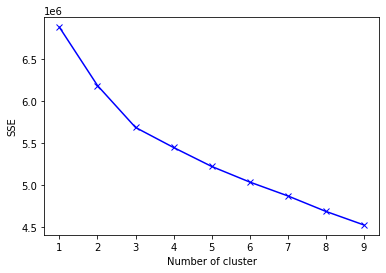

In [128]:
# Empty dictionary to store the SSE for each value of K
sse = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. 
# Use inertia attribute from the clustering object and store the inertia value for that K 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled2)
    sse[k] = kmeans.inertia_

# Elbow plot
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

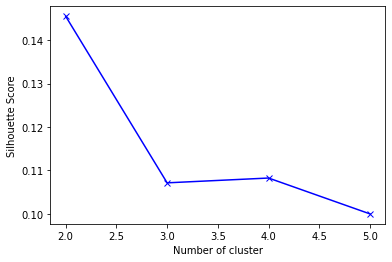

In [129]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {} 
#subset to a smaller samp;e
data_scaled3=data_scaled2.sample(n = 20000)
# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K 
for k in range(2, 6):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled3)
    labels = kmeans.predict(data_scaled3)
    sc[k] = silhouette_score(data_scaled3, labels)
# Elbow plot
plt.figure()

plt.plot(list(sc.keys()), list(sc.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("Silhouette Score")

plt.show()

In [130]:
kmeans = KMeans(n_clusters = 2, random_state = 1)
kmeans.fit(data_scaled2)
# Adding predicted labels to the original data and the scaled data 
data_scaled2['KMeans_Labels'] = kmeans.predict(data_scaled2)
data_scaled2['KMeans_Labels'].value_counts()

0    337036
1    165471
Name: KMeans_Labels, dtype: int64

In [131]:
# Calculating the mean and the median of the original data for each label
mean = data_scaled2.groupby('KMeans_Labels').mean()
median = data_scaled2.groupby('KMeans_Labels').median()
df_kmeans = pd.concat([mean, median], axis = 0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_0 Median', 'group_1 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_0 Median,group_1 Median
MOD_TOT,-0.351438,0.649562,-0.428962,0.144431
VIG_TOT,-0.309982,0.571758,-0.436081,0.178500
FREQ_WK_MOD_PHY.0.0,-0.437413,0.890135,-0.546063,1.044214
FREQ_WK_VIG_PHY.0.0,-0.479176,0.974225,-0.819261,1.141590
WHR.0.0,0.050770,-0.101960,0.012692,-0.048939
DIET_COOK_VEG.0.0,-0.141896,0.245774,-0.406015,0.114869
DIET_SALAD_RAW.0.0,-0.146790,0.275230,-0.125596,-0.125596
DIET_FRUIT_FRESH.0.0,-0.143400,0.271079,-0.181644,-0.181644
SLEEPDUR.0.0,-0.007131,0.014111,-0.075755,-0.075755
SUNLAMP.0.0,-0.026565,0.054102,-0.000201,-0.000201


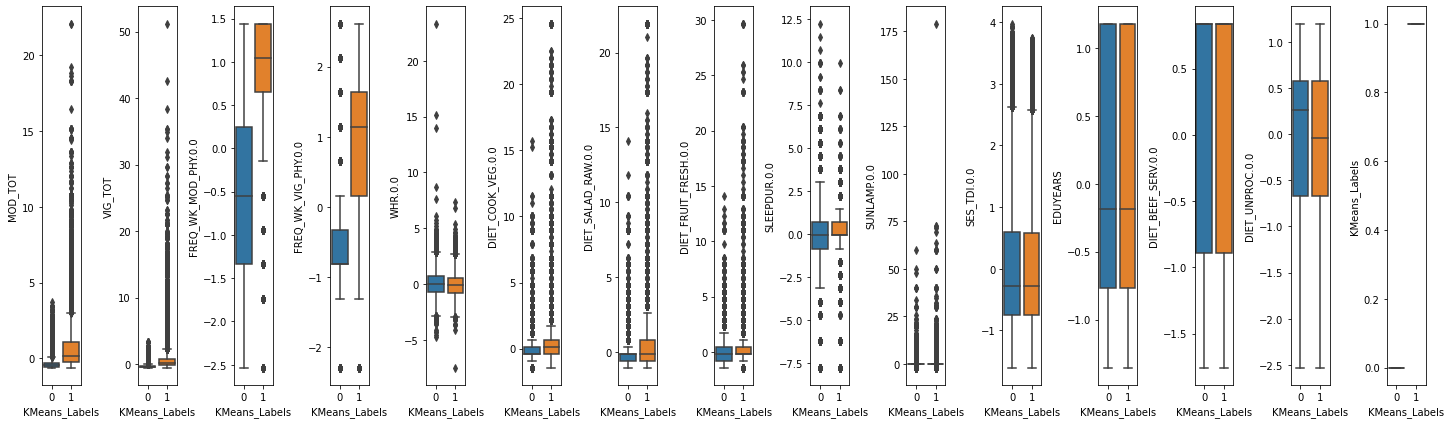

In [132]:
names = data_scaled2.columns
ncols = len(names)
fig, axes = plt.subplots(1,ncols, figsize = (20, 6))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "KMeans_Labels", data=data_scaled2, orient='v', ax=ax)
plt.tight_layout()

**Observations:**

- **Number of clusters** : The elbow plots and silhouellette plots supported identification of two distinct profiles based on healthy behaviors.
- **Interpretation of the behavioral clusters** : Group 0 engages in higher moderate and vigorous physical activity compared to group 1; group 0 engages in healthier behaviors with greater moderate-to-vigorous activity, 
and more frequently engage in physical activity; group 0 have a smaller waist hip circumference; they are more likely to consume cooked vegetables, salad, and fresh fruit; group 0 is less likely to consume beef products or 
unprocessed meat. Group 0 have a higher self-reported sleep duration as compared to group 1. Group 1 on the other hand is more sedentary as compared to group 0, and they consume food groups associated with greater cardiovascular disease risk (including processed food and red meat). There did not appear to be a difference in the structural determinants of health (including income, years of education, or geographically-based socioeconomic index) in distinguishing healthy from unhealthy behavioral profiles. 

## **Gaussian Mixture Model**

In [194]:
gmm = GaussianMixture(n_components = 2, random_state = 1)
gmm.fit(data_scaled2)
data_scaled2['GmmLabels'] = gmm.predict(data_scaled2)
data_scaled2.GmmLabels.value_counts()

1    270807
0    231700
Name: GmmLabels, dtype: int64

In [213]:
mean = data_scaled2.groupby('GmmLabels').mean()
median = data_scaled2.groupby('GmmLabels').median()
df_gmm = pd.concat([mean, median], axis = 0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_0 Median', 'group_1 Median']
df_gmm[num_cols].T

,group_0 Mean,group_1 Mean,group_0 Median,group_1 Median
MOD_TOT,0.168522,-0.184671,-0.361504,-0.361504
VIG_TOT,0.134901,-0.151851,-0.333651,-0.333651
FREQ_WK_MOD_PHY.0.0,0.081007,-0.069798,0.249076,-0.148494
FREQ_WK_VIG_PHY.0.0,0.089661,-0.077797,-0.329048,-0.329048
WHR.0.0,0.006551,-0.004719,0.012692,0.012692
DIET_COOK_VEG.0.0,0.070281,-0.086555,0.114869,-0.406015
DIET_SALAD_RAW.0.0,0.052924,-0.059796,-0.125596,-0.125596
DIET_FRUIT_FRESH.0.0,0.020151,-0.030074,-0.181644,-0.181644
SLEEPDUR.0.0,0.004209,-0.003853,-0.075755,-0.075755
SUNLAMP.0.0,0.001875,-0.001608,-0.000201,-0.000201


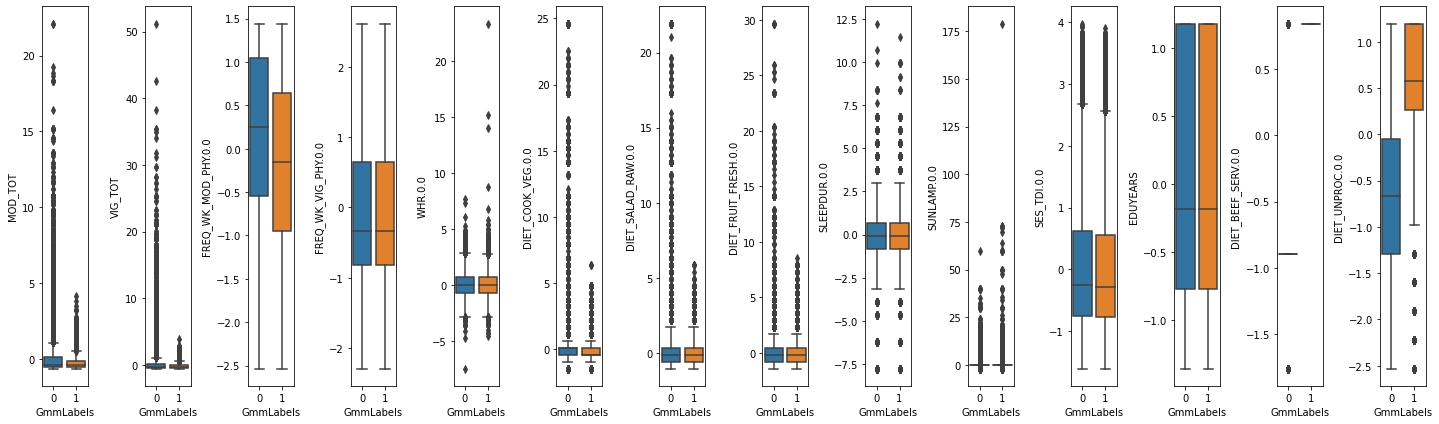

In [215]:
#names = data_scaled2.columns.drop(['KMeans_Labels','GmmLabels'])
ncols = len(names)
fig, axes = plt.subplots(1,ncols, figsize = (20, 6))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "GmmLabels", data=data_scaled2, orient='v', ax=ax)
plt.tight_layout()

## **DBSCAN**

In [136]:
dbs = DBSCAN(eps =2,min_samples=20)
data_scaled3['DBSLabels'] = dbs.fit_predict(data_scaled3) #use 20,000 individuals sampled individually
data_scaled3['DBSLabels'].value_counts()

 0    16424
-1     3517
 1       59
Name: DBSLabels, dtype: int64

In [138]:
mean = data_scaled3.groupby('DBSLabels').mean()
median = data_scaled3.groupby('DBSLabels').median()
df_hierachical = pd.concat([mean, median], axis = 0)
df_hierachical.index = ['group_-1 Mean', 'group_0 Mean','group_1 Mean', 'group_-1 Median', 'group_0 Median','group_1 Median']
df_hierachical[num_cols].T

,group_-1 Mean,group_0 Mean,group_1 Mean,group_-1 Median,group_0 Median,group_1 Median
MOD_TOT,0.710448,-0.187034,-0.341228,-0.091672,-0.361504,-0.395233
VIG_TOT,0.581264,-0.162173,-0.185995,-0.128790,-0.333651,-0.333651
FREQ_WK_MOD_PHY.0.0,0.434352,-0.085024,-0.229355,0.646645,-0.148494,-0.148494
FREQ_WK_VIG_PHY.0.0,0.506697,-0.112387,-0.104714,0.651377,-0.329048,-0.329048
WHR.0.0,0.012877,-0.000799,-0.150747,0.012692,0.012692,-0.100184
DIET_COOK_VEG.0.0,0.524083,-0.131143,-0.202959,0.114869,-0.406015,-0.406015
DIET_SALAD_RAW.0.0,0.666579,-0.143838,-0.258000,0.333926,-0.125596,-0.125596
DIET_FRUIT_FRESH.0.0,0.396267,-0.098284,-0.371331,-0.181644,-0.181644,-0.181644
SLEEPDUR.0.0,-0.256687,0.046515,0.236866,-0.075755,-0.075755,-0.075755
SUNLAMP.0.0,0.170837,-0.013770,-1.990082,-0.000201,-0.000201,-1.990082


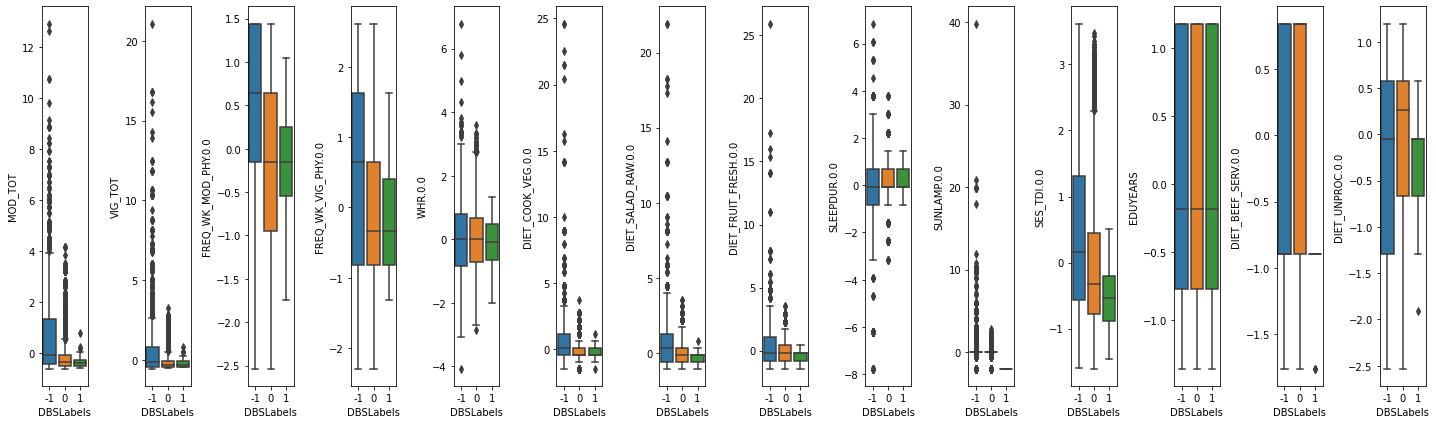

In [139]:
names = data_scaled3.columns.drop(['DBSLabels'])
ncols = len(names)
fig, axes = plt.subplots(1,ncols, figsize = (20, 6))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= 'DBSLabels', data=data_scaled3, orient='v', ax=ax)
plt.tight_layout()

**Observations:**

**DBSCAN Description:** A random sample of 20,000 participants was identified from a sample consisting of 500,000 individuals. The minimum distance was chosen so that the minimum thickness of the cluster was 20 participants; this parameter is to prevent the cluster from thinning out too much, in order to promote robustness of findings to distinct sub-groups. If the minimum distance was set to 50, then only one cluster was identified. When the minimum distance was not set, there were approximately 8 clusters with up to 10 clusters with 5 or 10 participants, with a majority of individuals in 2 groups. Setting the minimum distance to 20 helped identify these two primary clusters. An advantage of this DBSCAN approach as compared to K-Means and MOG is that the number of clusters was not identified prior to running the algorithm; it performs well with arbitrarily shaped clusters, since it is based off of density of points. Lastly, DBSCAN is robust to outliers which of concern with this data as seen in the box plots.

**Number of clusters:** Two clusters; generally agreement between clustering approaches 

**Interpretation of the behavioral clusters:** Two similar groups are identified that mirrors the prior approaches; the main difference that DBSCAN identified was that the healthier group had lower socioeconomic disadvantage.

**Recommendations:** Two distinct behavioral profiles are emerging that are not particularly sensitive to the clustering approach; would recommend DBSCAN be adopted, since it is known that those of higher socioeconomic status often engage in other behaviors not already captured by the metrics for physical activity, diet, and sleep, including substance use. A limitation of this analysis is that substance use is likely a predictor of long-term chronic disease risk, which was not available in this version of the dataset. Using a measure of socioeconomic status may capture some key behaviors missed, such as substance use. Ideally, this approach would exclude socioeconomic status and instead these other behaviors more directly.

###  **Preparing data for modeling**

Our primary objective is to understand characterize the relationship between behavioral profiles and risk of diabetic and non-diabetic kidney disease; we will then explore whether there is a genetic and environmental (GXE) interaction between insulin resistance polygenic risk scores and these behavioral profiles. DBSCAN is very slow for this use case and exceeded memory of 100GB for ~500,000 participants; instead will use mixtures of gaussian since the profiles are very similar.

- First, need to merge the labels back to the original dataset prior to any transformations.

In [201]:
original_cols = ['f.eid','AGE.0.0','SEX.0.0','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','EDUYEARS','SES_TDI.0.0','BMI.0.0','GRS_WT_IR','GRS_WT_T2DIR','T2D.0.0','CKD.0.0','ALBUMINERIA.0.0','ESKD.0.0',
                'DN.0.0','ALL.0.0']
df4=df3.get(original_cols)
#df4.head()

#### Define the Kidney Disease Endpoints based on Clinical Definitions

In [202]:
#Outcome 1 - chronic kidney disease
df4['CKD_only.0.0'] = '' 
df4.loc[(df4['CKD.0.0'] == 'CKD'), 'CKD_only.0.0'] = 'CKD'
df4.loc[(df4['CKD.0.0'] == 'CKD controls'), 'CKD_only.0.0'] = 'CKD controls'
#Outcome 2 - microalbumerina (earlier stage kidney disease (KD))
df4['micro'] = ''
df4.loc[(df4['ALBUMINERIA.0.0'] == 'micro'), 'micro'] = 'micro'
df4.loc[(df4['ALBUMINERIA.0.0'] == 'normo'), 'micro'] = 'normo'
#Outcome 3 - later stage kidney disease, macroalbumineria 
df4['macro'] = ''
df4.loc[(df4['ALBUMINERIA.0.0'] == 'macro'), 'macro'] = 'macro'
df4.loc[(df4['ALBUMINERIA.0.0'] == 'normo'), 'macro'] = 'normo'
#combine the dataset with the other file
df4 = pd.concat([data_scaled2.get('GmmLabels'),df4],axis=1)

In [203]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502507 entries, 0 to 502506
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   GmmLabels        502507 non-null  int64  
 1   f.eid            502507 non-null  int64  
 2   AGE.0.0          500837 non-null  float64
 3   SEX.0.0          500837 non-null  object 
 4   PC1              373487 non-null  float64
 5   PC2              373487 non-null  float64
 6   PC3              373487 non-null  float64
 7   PC4              373487 non-null  float64
 8   PC5              373487 non-null  float64
 9   PC6              373487 non-null  float64
 10  PC7              373487 non-null  float64
 11  PC8              373487 non-null  float64
 12  PC9              373487 non-null  float64
 13  PC10             373487 non-null  float64
 14  EDUYEARS         490740 non-null  float64
 15  SES_TDI.0.0      500216 non-null  float64
 16  BMI.0.0          497769 non-null  floa

In [204]:
#create dummy variables
cat_vars=['CKD_only.0.0','SEX.0.0','micro','macro']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df4[var], prefix=var)
    df5=df4.join(cat_list)
    df4=df5
data_vars=df4.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
df4=df4[to_keep]
df4.columns.values

array(['GmmLabels', 'f.eid', 'AGE.0.0', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5',
       'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'EDUYEARS', 'SES_TDI.0.0',
       'BMI.0.0', 'GRS_WT_IR', 'GRS_WT_T2DIR', 'T2D.0.0', 'CKD.0.0',
       'ALBUMINERIA.0.0', 'ESKD.0.0', 'DN.0.0', 'ALL.0.0',
       'CKD_only.0.0_', 'CKD_only.0.0_CKD', 'CKD_only.0.0_CKD controls',
       'SEX.0.0_Female', 'SEX.0.0_Male', 'micro_', 'micro_micro',
       'micro_normo', 'macro_', 'macro_macro', 'macro_normo'],
      dtype=object)

In [205]:
#rename dataset for easier glm stat model usage
df4.rename(columns = {'CKD_only.0.0_CKD':'CKD','macro_macro':'macro','micro_micro':'micro', 'AGE.0.0':'AGE','SEX.0.0_Male':'Male','SES_TDI.0.0':'SES','T2D.0.0':'T2D','GmmLabels':'BEHAV'}, inplace = True)

In [206]:
# del df3
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502507 entries, 0 to 502506
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   BEHAV                      502507 non-null  int64  
 1   f.eid                      502507 non-null  int64  
 2   AGE                        500837 non-null  float64
 3   PC1                        373487 non-null  float64
 4   PC2                        373487 non-null  float64
 5   PC3                        373487 non-null  float64
 6   PC4                        373487 non-null  float64
 7   PC5                        373487 non-null  float64
 8   PC6                        373487 non-null  float64
 9   PC7                        373487 non-null  float64
 10  PC8                        373487 non-null  float64
 11  PC9                        373487 non-null  float64
 12  PC10                       373487 non-null  float64
 13  EDUYEARS                   49

In [211]:
df4.get(['CKD','micro','macro','BEHAV']).describe().T

,count,mean,std,min,25%,50%,75%,max
CKD,502507.0,0.016678,0.128063,0.0,0.0,0.0,0.0,1.0
micro,502507.0,0.040202,0.196434,0.0,0.0,0.0,0.0,1.0
macro,502507.0,0.003841,0.061855,0.0,0.0,0.0,0.0,1.0
BEHAV,502507.0,0.538912,0.498484,0.0,0.0,1.0,1.0,1.0


Dummy variables of 1 correspond to an individual with type 2 diabetes, chronic kidney disease, and male gender.

### Logistic Regression Modeling for Kidney Disease

In [207]:
def oddsratio(results):
    model_odds = pd.DataFrame(np.exp(results.params), columns= ['OR'])
    model_odds['z-value']= results.pvalues
    model_odds[['2.5%', '97.5%']] = np.exp(results .conf_int())
    return(model_odds)

In [208]:
for i in ["CKD","micro","macro"]:
    model = logit(i + "~" " BEHAV", data=df4)
    results = model.fit()
    print(results.summary())
    print(oddsratio(results))

Optimization terminated successfully.
         Current function value: 0.084806
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    CKD   No. Observations:               502507
Model:                          Logit   Df Residuals:                   502505
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Jun 2022   Pseudo R-squ.:               8.735e-05
Time:                        14:26:40   Log-Likelihood:                -42616.
converged:                       True   LL-Null:                       -42620.
Covariance Type:            nonrobust   LLR p-value:                  0.006358
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1098      0.016   -249.334      0.000      -4.142      -4.078
BEHAV          0.0604      0.

Observations: Profile 1 is less healthy compared to profile 0. Associations are in the reverse direction for micro and macroalbumineria but in the expected direction for CKD. We'll focus on CKD for the rest of this analysis.

In [218]:
for i in ["T2D","AGE","GRS_WT_IR","Male"]:
    model = logit("CKD" "~" " BEHAV*"+i, data=df4)
    results = model.fit()
    print(results.summary())
    print(oddsratio(results))

Optimization terminated successfully.
         Current function value: 0.084348
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    CKD   No. Observations:               500837
Model:                          Logit   Df Residuals:                   500833
Method:                           MLE   Df Model:                            3
Date:                Wed, 08 Jun 2022   Pseudo R-squ.:                0.008140
Time:                        14:43:33   Log-Likelihood:                -42245.
converged:                       True   LL-Null:                       -42591.
Covariance Type:            nonrobust   LLR p-value:                5.793e-150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1938      0.018   -236.529      0.000      -4.229      -4.159
BEHAV          0.0629      0.

In [258]:
model = logit("CKD" "~" "BEHAV+GRS_WT_IR + AGE + Male + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES + T2D", data=df4)
results = model.fit()
print(results.summary())
oddsratio(results)

Optimization terminated successfully.
         Current function value: 0.076884
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    CKD   No. Observations:               369682
Model:                          Logit   Df Residuals:                   369664
Method:                           MLE   Df Model:                           17
Date:                Wed, 08 Jun 2022   Pseudo R-squ.:                 0.07618
Time:                        15:38:34   Log-Likelihood:                -28423.
converged:                       True   LL-Null:                       -30767.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.9070      0.179    -66.395      0.000     -12.258     -11.555
BEHAV          0.0428      0.

,OR,z-value,2.5%,97.5%
Intercept,0.000007,0.000000e+00,0.000005,0.000010
BEHAV,1.043762,1.040996e-01,0.991219,1.099090
GRS_WT_IR,1.612598,1.763261e-02,1.086773,2.392837
AGE,1.138502,0.000000e+00,1.133145,1.143884
Male,0.854536,3.789630e-09,0.811008,0.900401
PC1,6.474930,1.658558e-02,1.404651,29.847078
PC2,0.059538,2.780001e-03,0.009375,0.378126
PC3,4.155903,3.631533e-01,0.192868,89.550820
PC4,1.695146,7.219265e-01,0.092661,31.011089
PC5,0.003332,4.858747e-04,0.000135,0.082147


In [221]:
for i in ["GRS_WT_IR","Male"]:
    model = logit("CKD" "~" "BEHAV+GRS_WT_IR + AGE + Male + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES + T2D + BEHAV*" + i, data=df4)
    results = model.fit()
    print(results.summary())
    print(oddsratio(results))

Optimization terminated successfully.
         Current function value: 0.076880
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    CKD   No. Observations:               369682
Model:                          Logit   Df Residuals:                   369663
Method:                           MLE   Df Model:                           18
Date:                Wed, 08 Jun 2022   Pseudo R-squ.:                 0.07623
Time:                        14:46:05   Log-Likelihood:                -28421.
converged:                       True   LL-Null:                       -30767.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -12.0565      0.200    -60.313      0.000     -12.448     -11.665
BEHAV         

In [161]:
for i in ["GRS_WT_IR","Male"]:
    model = logit("CKD" "~" "BEHAV+GRS_WT_IR + AGE + Male + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES + T2D + BEHAV*" + i, data=df4)
    results = model.fit()
    print(results.summary())
    print(oddsratio(results))

Optimization terminated successfully.
         Current function value: 0.076832
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    CKD   No. Observations:               369682
Model:                          Logit   Df Residuals:                   369663
Method:                           MLE   Df Model:                           18
Date:                Wed, 08 Jun 2022   Pseudo R-squ.:                 0.07681
Time:                        12:17:31   Log-Likelihood:                -28403.
converged:                       True   LL-Null:                       -30767.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.8378      0.186    -63.599      0.000     -12.203     -11.473
BEHAV         

,OR,z-value,2.5%,97.5%
Intercept,0.000007,0.000000e+00,0.000005,0.000010
BEHAV,0.784246,1.657916e-01,0.556134,1.105923
GRS_WT_IR,1.545492,6.887074e-02,0.966892,2.470334
BEHAV:GRS_WT_IR,1.167264,7.265401e-01,0.490614,2.777146
AGE,1.138869,0.000000e+00,1.133505,1.144259
Male,0.856525,6.464883e-09,0.812883,0.902510
PC1,7.021462,1.243266e-02,1.523139,32.367964
PC2,0.056470,2.308300e-03,0.008893,0.358590
PC3,3.508092,4.227296e-01,0.163115,75.447962
PC4,1.705114,7.188391e-01,0.093335,31.150215


In [235]:
#Predict new datapoints for visualization
df4_copy=df4.get(['CKD','BEHAV','GRS_WT_IR','AGE','Male','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','EDUYEARS','SES','T2D']).dropna()
print(df4_copy.shape)
model = logit("CKD" "~" "BEHAV*GRS_WT_IR+ AGE + Male + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + EDUYEARS + SES + T2D", data=df4_copy)
results = model.fit()
df4_copy['predy']=results.predict(df4_copy)

(369682, 18)
Optimization terminated successfully.
         Current function value: 0.076880
         Iterations 9


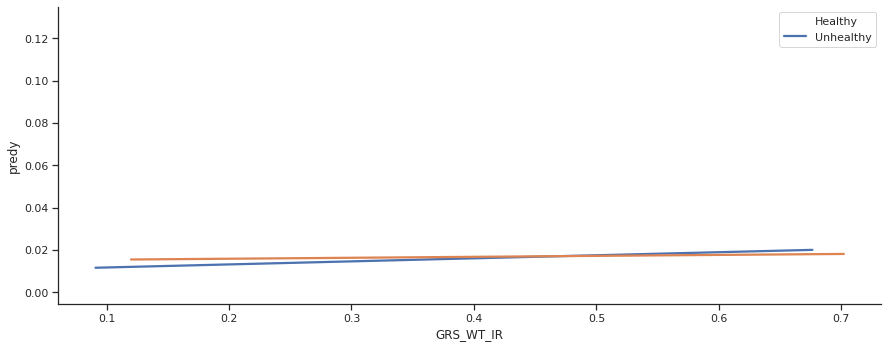

In [256]:
sns.set(style="ticks", color_codes=True)
g=sns.lmplot(x='GRS_WT_IR', y='predy', hue='BEHAV', data=df4_copy, ci=None, size=5, aspect=2.5, scatter_kws={"s": 0.0},legend=False);
plt.legend(labels=["Healthy","Unhealthy"])
plt.show()